In [1]:
using Pkg
for p in ("Knet","Images","ImageMagick", "MAT")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end
using Knet, MAT, Images, Random
using Base.Iterators: flatten, cycle, take
using IterTools
using Statistics: mean
using Plots; default(fmt=:png,ls=:auto)
include(Knet.dir("data","imagenet.jl"))
import Base: length, size, iterate

In [2]:
model = matconvnet("imagenet-resnet-101-dag")

┌ Info: Loading imagenet-resnet-101-dag.mat...
└ @ Main /home/cankucuksozen/.julia/packages/Knet/vxHRi/data/imagenet.jl:14


Dict{String,Any} with 4 entries:
  "meta"   => Dict{String,Any}("classes"=>Dict{String,Any}("name"=>Any["n014407…
  "params" => Dict{String,Any}("name"=>Any["conv1_filter" "bn_conv1_mult" … "fc…
  "vars"   => Dict{String,Any}("name"=>Any["data" "conv1" … "fc1000" "prob"],"p…
  "layers" => Dict{String,Any}("name"=>Any["conv1" "bn_conv1" … "fc1000" "prob"…

In [4]:
function preprocess_img(img, average_img)
    
    new_size = ntuple(i->div(size(img,i)*224,minimum(size(img))),2)
    a1 = Images.imresize(img, new_size)
    i1 = div(size(a1,1)-224,2)
    j1 = div(size(a1,2)-224,2)
    b1 = a1[i1+1:i1+224,j1+1:j1+224]
    c1 = channelview(b1)
    if ndims(c1) != 3 # image is grayscale
        c1 = reshape(c1,(1,224,224))
        temp = cat(c1, c1, dims =1)
        c1 = cat(temp, c1, dims =1)
    end
    d1 = convert(Array{Float32}, c1)
    e1 = reshape(d1, (224,224,3,1))
    f1 = (255 * e1 .- average_img)
    g1 = permutedims(f1, [2,1,3,4])
    
    return g1

end

preprocess_img (generic function with 1 method)

In [5]:
struct imagenet_minibatch
    classes
    class_to_label
    class_descriptions
    data_path
    samples_list
    batchsize
    shuffle
    mode
    ninstances 
    avgimg
end

In [6]:
function imagenet_minibatch(model; batchsize = 4, shuffle = true, mode = "train")
    
    root_path = "/media/cankucuksozen/CAN HD/Can/image_net/imagenet-object-localization-challenge/ILSVRC/"
    samples_path = joinpath(root_path, "ImageSets/CLS-LOC/")
    data_path = joinpath(root_path, "Data/CLS-LOC/train")
    
    classes = model["meta"]["classes"]["name"]
    labels = reshape(collect(1:length(classes)),(1,:))
    class_to_label = Dict(classes .=> labels)
    
    class_descriptions = model["meta"]["classes"]["description"]
    
    avgimg = model["meta"]["normalization"]["averageImage"]
    avgimg = convert(Array{Float32}, avgimg) 
    
    if mode == "train"
        trn_smp_txt_path = joinpath(samples_path, "train_cls_mini.txt")
        trn_samples_file = open(trn_smp_txt_path)
        trn_samples = readlines(trn_samples_file)
        trn_ninstances = length(trn_samples)
    end 
    
    return imagenet_minibatch(classes, class_to_label, class_descriptions, data_path, trn_samples, 
                                batchsize, shuffle, mode, trn_ninstances, avgimg)
end

imagenet_minibatch

In [7]:
function length(d::imagenet_minibatch)
    batch_count, remains = divrem(d.ninstances, d.batchsize)
    return (remains == 0 ? batch_count : batch_count + 1)
end

length (generic function with 206 methods)

In [8]:
function iterate(d::imagenet_minibatch, 
    state=ifelse( d.shuffle, randperm(d.ninstances), collect(1:d.ninstances)))

    inds = state; 
    inds_len = length(inds) 
    max_ind = 0
    
    if inds_len == 0 
        return nothing
    else
        batch_img = []
        batch_label = []
        max_ind = min(inds_len, d.batchsize)
        
        for i in range(1, stop = max_ind)
            samp = d.samples_list[inds[i]]
            class = split(samp, "/")[1]
            label = d.class_to_label[class]
            img_ext = (split(samp, " ")[1]) * ".JPEG"
            img_path = joinpath(d.data_path, img_ext)
            img = Images.load(img_path)
            img = preprocess_img(img, d.avgimg)
            img = KnetArray(img)
            push!(batch_img, img)
            push!(batch_label, label)
        end
        
        img = cat(batch_img..., dims = 4)
        labels = hcat(batch_label...)

        deleteat!(inds, 1:max_ind)

        return ((img,labels), inds)
    end
end

iterate (generic function with 407 methods)

In [9]:
struct Conv
    w
    stride
    padding
end

function Conv(w1::Int, w2::Int, cx::Int, cy::Int; stride = 1, padding = 0)
    w = param(w1, w2, cx, cy)
    return Conv(w, stride, padding)
end

function (c::Conv)(x)
    return conv4(c.w, x ; padding = c.padding, stride = c.stride)
end

In [10]:
struct Conv1x1
    w
    stride
    padding
end

function Conv1x1(cx::Int, cy::Int; stride = 1, padding = 0)
    w = param(1, 1, cx, cy)
    return Conv1x1(w, stride, padding)
end

function (c::Conv1x1)(x)
    return conv4(c.w, x ; padding = c.padding, stride = c.stride)
end

In [11]:
struct Conv3x3
    w
    stride
    padding
end

function Conv3x3(cx::Int, cy::Int; stride = 1, padding = 1)
    w = param(3, 3, cx, cy)
    return Conv3x3(w, stride, padding)
end

function (c::Conv3x3)(x)
    return conv4(c.w, x ; padding = c.padding, stride = c.stride)
end

In [12]:
struct Dense
    w
    b
end
function Dense(i::Int,o::Int)     
    w = param(o,i)
    b = param0(o)
    return Dense(w,b)
end

function (d::Dense)(x)
    return d.w * mat(x) .+ d.b
end

In [13]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
#(c::Chain)(x,y) = nll(c(x),y, average = true)
#(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [14]:
struct Batchnorm
    w
    m
end 

function Batchnorm(w1::Int)
    w = KnetArray(bnparams(Float32, w1))
    m = bnmoments()
    return Batchnorm(w,m)
end

function (b::Batchnorm)(x)
    return batchnorm(x, b.m, b.w)
end

In [15]:
struct RelEmbed
    weight
end

function RelEmbed(num_relative::Int, embed_channels::Int) 
    w = Param(KnetArray{Float32}(gaussian(embed_channels,num_relative; mean = 0.0 , std = (embed_channels^-0.5))))
    return RelEmbed(w)
end

RelEmbed

In [16]:
function flatten_hw(input, d)
    h, w, _, Nh, b = size(input)
    return reshape(input, (h*w, d, Nh, :))
end

flatten_hw (generic function with 1 method)

In [17]:
function split_heads_2d(inputs, Nh)
    h, w, d, b = size(inputs)
    ret_shape = (h, w, floor(Int,d/Nh), Nh, b)
    out = reshape(inputs, ret_shape)
    #out = permutedims(split, [1,4,2,3,5])
    return out
end

split_heads_2d (generic function with 1 method)

In [18]:
function combine_heads_2d(inputs)
    h, w, dh, Nh, b  = size(inputs)
    ret_shape = (h,w, dh*Nh, b)
    return reshape(inputs, ret_shape)
end

combine_heads_2d (generic function with 1 method)

In [19]:
function rel_to_abs(x)
    b, Nh, l, _ = size(x)
    col_pad = KnetArray{Float32}(zeros((b, Nh, l, 1)))
    x = cat(x, col_pad; dims = 4)
    flat_x = reshape(x, (b, Nh, l*2*l))
    flat_pad = KnetArray{Float32}(zeros((b, Nh, l-1)))
    flat_x_padded = cat(flat_x, flat_pad; dims = 3)
    final_x = reshape(flat_x_padded, (b, Nh, l+1, 2*l-1))
    final_x = final_x[:, :, 1:l, l:end]
    return final_x
end

rel_to_abs (generic function with 1 method)

In [20]:
function relative_logits_1d(q, rel_k, h, w, Nh, transpose_mask)
    
    _, _, d, _, b = size(q)
    flat_q = flatten_hw(q, d)
    
    rel_k = reshape(rel_k, (d, :, 1, 1))
    rel_k_rep = copy(rel_k)
    for _ in range(1, stop = Nh-1)
        rel_k_rep = cat(rel_k_rep, rel_k, dims = 3)
    end
    rel_k = copy(rel_k_rep)
    for _ in range(1, stop = b-1)
        rel_k = cat(rel_k, rel_k_rep, dims = 4)
    end
    
    rel_logits = bmm(flat_q, rel_k)
        
    #println(size(rel_logits))
    
    
    #=rel_logits = KnetArray{Float32}(zeros((h*w, 2*w-1, Nh, b))); #display(size(rel_logits))
    for i in range(1, stop = b)
        for j in range(1, stop = Nh)
            temp = flat_q[:,:,j,i] * rel_k
            rel_logits[:,:,j,i] = temp
        end
    end
    =#
    
    rel_logits = reshape(rel_logits, (h,w,:,Nh,b))
    rel_logits = permutedims(rel_logits, [5,4,2,1,3])
    rel_logits = reshape(rel_logits, (:, Nh*h, w, 2*w-1))
    rel_logits = rel_to_abs(rel_logits)
    rel_logits = reshape(rel_logits, (:, Nh, h, 1, w, w))
    rel_logits_rep = copy(rel_logits)
    for i in range(1, stop = h-1) #NOT SURE IF THIS SUPPORTS AUTOGRAD
        rel_logits_rep = cat(rel_logits_rep, rel_logits, dims = 4)
    end
    rel_logits = permutedims(rel_logits_rep, transpose_mask)
    rel_logits = reshape(rel_logits, (:, Nh, h*w, h*w))
    return rel_logits
end

relative_logits_1d (generic function with 1 method)

In [21]:
function pad_zeros(img, kernel_size)
    pad = Int(floor(kernel_size/2))
    h,w,c,b = size(img)
    c_pad = KnetArray{Float32}(zeros((h,pad,c,b))); #display(size(c_pad))
    r_pad = KnetArray{Float32}(zeros((pad,w+2*pad,c,b))); #display(size(r_pad))
    img_temp_p = cat(c_pad,img, dims = 2); #display(size(img_temp_p))
    img_temp_p = cat(img_temp_p,c_pad, dims = 2); #display(size(img_temp_p))
    img_temp_p = cat(r_pad,img_temp_p, dims = 1); #display(size(img_temp_p))
    img_temp_p = cat(img_temp_p,r_pad, dims = 1); #display(size(img_temp_p))
    return img_temp_p
end

pad_zeros (generic function with 1 method)

function odims(input, kernel_size, dv)
    #assume stride = 1
    inh,inw,inc,b = size(input)
    pad = Int(floor(kernel_size/2))
    out_dims_h = ((inh-kernel_size) + 2*pad) + 1
    out_dims = (out_dims_h, out_dims_h, dv, b)
    return out_dims
end

In [22]:
function odims(input, kernel_size, dv)
    #assume stride = 1
    inh,inw,inc,b = size(input)
    pad = Int(floor(kernel_size/2))
    out_dims_h = ((inh-kernel_size) + 2*pad) + 1
    out_dims_flat = (1, dv, b)
    out_dims_orig = (out_dims_h, out_dims_h, dv, b)
    return out_dims_flat, out_dims_orig
end

odims (generic function with 1 method)

In [23]:
function im2col(x, kernel_size)
    #Assumes stride = 1 and necessary padding for input_h = output_h
    out_h = size(x,1)
    x = pad_zeros(x, kernel_size)
    imh, imw, imc, b = size(x)
    x = reshape(x, (imh*imw, imc, b))
    
    out = reshape(x[1:kernel_size,:,:],(kernel_size,1, imc,b))
    for i in range(2, stop = kernel_size)
        temp = reshape(x[(i-1)*imh+1: (i-1)*imh+1 + kernel_size-1, :, :], (kernel_size, 1, imc,b))
        out = cat(out, temp, dims = 1)
    end
    
    for i in range(2, stop = out_h*out_h)
        next_out = reshape(x[i: i+kernel_size-1, :, :], (kernel_size,1,imc,b))
        for j in range(2, stop = kernel_size)
            temp = reshape(x[(j-1)*imh+i: (j-1)*imh+i + kernel_size-1, :, :], (kernel_size,1, imc,b))
            next_out = cat(next_out, temp, dims = 1 )
        end
        out = cat(out,next_out, dims = 2)
    end
    
    return out
end

im2col (generic function with 1 method)

In [24]:
struct self_attention_2d
    conv_q
    conv_k
    conv_v
    conv_attn
    rel_embed_h
    rel_embed_w
    kernel_size
    dk
    dv
    Nh
    dkh
    dvh
end

In [25]:
function self_attention_2d(input_dims, kernel_size, Nh, dk, dv)
    conv_q = Conv(1,1, input_dims, dk)
    conv_k = Conv(1,1, input_dims, dk)
    conv_v = Conv(1,1, input_dims, dv)
    conv_attn = Conv(1,1, dv, dv)
    
    dkh = floor(Int, dk/Nh)
    dvh = floor(Int, dv/Nh)
    
    rel_embed_h = RelEmbed(2*kernel_size-1, dkh)
    rel_embed_w = RelEmbed(2*kernel_size-1, dkh)
    
    return self_attention_2d(conv_q, conv_k, conv_v, conv_attn, rel_embed_h,
                                rel_embed_w, kernel_size, dk, dv, Nh, dkh, dvh)
end

self_attention_2d

In [26]:
function (s::self_attention_2d)(x)
    
    _, _, _, b = size(x)
    q = s.conv_q(x)
    k = s.conv_k(x)
    v = s.conv_v(x)
    
    q = q .* (s.dkh ^ -0.5)
    
    q = split_heads_2d(q,s.Nh)
    k = split_heads_2d(k,s.Nh)
    v = split_heads_2d(v,s.Nh)
    
    flat_q = flatten_hw(q, s.dkh)
    flat_k = flatten_hw(k, s.dkh)
    flat_v = flatten_hw(v, s.dvh)
    logits = bmm(flat_q, flat_k, transB = true)
    
    rel_h = s.rel_embed_h.weight
    rel_w = s.rel_embed_w.weight
    
    q_in_w = copy(q)
    q_in_w = permutedims(q_in_w, [2,1,3,4,5])
    
    rel_logits_h = relative_logits_1d(q, rel_h, s.kernel_size, s.kernel_size, s.Nh, [1, 2, 3, 5, 4, 6])
    rel_logits_w = relative_logits_1d(q_in_w, rel_w, s.kernel_size, s.kernel_size, s.Nh, [1, 2, 5, 3, 6, 4])
    
    logits = permutedims(logits, [4,3, 1,2])
    
    logits += rel_logits_h
    logits += rel_logits_w
    
    weights = softmax(logits; dims = 4)
    weights = permutedims(weights, [3,4,2,1])

    attn_out = bmm(weights, flat_v)
    attn_out = reshape(attn_out, (s.kernel_size, s.kernel_size, s.dvh, s.Nh, :))
    attn_out = combine_heads_2d(attn_out) 

    attn_out = s.conv_attn(attn_out)
end

function (s::self_attention_2d)(x)
    
    out_dims = odims(x, s.kernel_size, s.dv)
    out = KnetArray{Float32}(zeros(out_dims))
    x = pad_zeros(x, s.kernel_size)
    imh, imw, imc, b = size(x)
    
    #assumes square input spattially, needs reimplementing for efficiency issues.
    #Most probably going to reshape input tensor like im2col. then modify inner calculations
    #according to new dimensions?
    
    ##Also, implemented 2d relative logits from Augmented Attention paper, which
    ##stores tensors in another format compared to knet ops. need to get rid
    ##of some permutedims operations
    for i in range(1, stop = imh - s.kernel_size + 1)
        for j in range(1, stop = imw - s.kernel_size + 1)

            x_patch = x[i:i+s.kernel_size-1, j:j+s.kernel_size-1, :, :]
            q = s.conv_q(x_patch)
            k = s.conv_k(x_patch)
            v = s.conv_v(x_patch)

            q = q .* (s.dkh ^ -0.5)

            q = split_heads_2d(q,s.Nh)
            k = split_heads_2d(k,s.Nh)
            v = split_heads_2d(v,s.Nh)

            flat_q = flatten_hw(q, s.dkh)
            flat_k = flatten_hw(k, s.dkh)
            flat_v = flatten_hw(v, s.dvh)
            logits = bmm(flat_q, flat_k, transB = true)

            rel_h = s.rel_embed_h.weight
            rel_w = s.rel_embed_w.weight

            q_in_w = copy(q)
            q_in_w = permutedims(q_in_w, [2,1,3,4,5])

            rel_logits_h = relative_logits_1d(q, rel_h, s.kernel_size, s.kernel_size, s.Nh, [1, 2, 3, 5, 4, 6])
            rel_logits_w = relative_logits_1d(q_in_w, rel_w, s.kernel_size, s.kernel_size, s.Nh, [1, 2, 5, 3, 6, 4])

            logits = permutedims(logits, [4,3, 1,2])

            logits += rel_logits_h
            logits += rel_logits_w

            weights = softmax(logits; dims = 4)
            weights = permutedims(weights, [3,4,2,1])

            attn_out = bmm(weights, flat_v)
            attn_out = reshape(attn_out, (s.kernel_size, s.kernel_size, s.dvh, s.Nh, :))
            attn_out = combine_heads_2d(attn_out) 

            attn_out = s.conv_attn(attn_out)
            
            attn_out = reshape(attn_out, (s.kernel_size*s.kernel_size, s.dv, :))
            attn_out = sum(attn_out, dims = 1)
            
            out[i,j] = attn_out
        end
    end
    
    return out

end

In [27]:
struct Bottleneck_Conv
    expansion
    conv1
    bn1
    conv2
    bn2
    conv3
    bn3
    activation
    downsample
    stride
end

function Bottleneck_Conv(inplanes, planes, expansion; stride = 1, is_downsample = false, groups = 1, 
                        base_width = 64, dilation = 1)
    
    width = Int(planes * (base_width / 64.)) * groups
    
    conv1 = Conv1x1(inplanes,width)
    bn1 = Batchnorm(width)
    conv2 = Conv3x3(width,width, stride = stride, padding = dilation)
    bn2 = Batchnorm(width)
    conv3 = Conv1x1(width, planes*expansion)
    bn3 = Batchnorm(planes*expansion)
    activation = relu
    
    if is_downsample
        downsample = Chain(Conv1x1(inplanes, planes*expansion, stride = stride),
                            Batchnorm(planes*expansion))
    else
        downsample = nothing
    end
    
    return Bottleneck_Conv(expansion, conv1, bn1, conv2, bn2, conv3, bn3, activation, downsample, stride)
end

function (b::Bottleneck_Conv)(x)
    identity = x
    
    out = b.conv1(x)
    out = b.bn1(out)
    out = b.activation.(out)
    
    out = b.conv2(out)
    out = b.bn2(out)
    out = b.activation.(out)
    
    out = b.conv3(out)
    out = b.bn3(out)
    
    if b.downsample != nothing
        identity = b.downsample(x)
    end
    
    out += identity
    out = b.activation.(out)
    
    return out
    
end

In [28]:
struct Bottleneck_Attn
    expansion
    conv1
    bn1
    self_attn
    bn2
    conv3
    bn3
    activation
    downsample
    stride
end

function Bottleneck_Attn(inplanes, kernel_size, planes, expansion; stride = 1, is_downsample = false, groups = 1, 
                        base_width = 64, dilation = 1)
    
    width = Int(planes * (base_width / 64.)) * groups
    
    conv1 = Conv1x1(inplanes,width)
    bn1 = Batchnorm(width)
    self_attn = self_attention_2d(width, kernel_size, 8, width, width)
    bn2 = Batchnorm(width)
    conv3 = Conv1x1(width, planes*expansion)
    bn3 = Batchnorm(planes*expansion)
    activation = relu
    
    if is_downsample
        downsample = Chain(Conv1x1(inplanes, planes*expansion, stride = stride),
                            Batchnorm(planes*expansion))
    else
        downsample = nothing
    end
    
    return Bottleneck_Attn(expansion, conv1, bn1, self_attn, bn2, conv3, bn3, activation, downsample, stride)
end

function (b::Bottleneck_Attn)(x)
    
    identity = x
    
    out = b.conv1(x)
    out = b.bn1(out)
    out = b.activation.(out)
    
    out = b.self_attn(out)
    if b.stride != 1
        out = pool(out)
    end
    out = b.bn2(out)
    out = b.activation.(out)
    
    out = b.conv3(out)
    out = b.bn3(out)
    
    if b.downsample != nothing
        identity = b.downsample(x)
    end
    
    out += identity
    out = b.activation.(out)
    
    return out
    
end

In [29]:
function _make_conv_layer(self_inplanes, block, block_expansion, planes, blocks; stride = 1) #dilate = False
    is_downsample = false
    if stride != 1 || self_inplanes != planes * block_expansion
        is_downsample = true
    end
    layers = []
    push!(layers, block(self_inplanes, planes, block_expansion; stride = stride, is_downsample = is_downsample))
    self_inplanes = planes * block_expansion
    for _ in range(1, stop = blocks)
        push!(layers, block(self_inplanes, planes, block_expansion))
    end
    return Chain(layers...), self_inplanes
end 

_make_conv_layer (generic function with 1 method)

In [30]:
function _make_attn_layer(self_inplanes, kernel_size, block, block_expansion, planes, blocks; stride = 1) #dilate = False
    is_downsample = false
    if stride != 1 || self_inplanes != planes * block_expansion
        is_downsample = true
    end
    layers = []
    push!(layers, block(self_inplanes, kernel_size, planes, block_expansion; stride = stride, is_downsample = is_downsample))
    self_inplanes = planes * block_expansion
  
    kernel_size = Int(kernel_size / 2)
    for _ in range(1, stop = blocks)
        push!(layers, block(self_inplanes, kernel_size, planes, block_expansion))
    end
    return Chain(layers...), self_inplanes
end 

_make_attn_layer (generic function with 1 method)

In [31]:
mutable struct ResNetAttn
    base_width
    conv_i
    bn_i
    activation
    max_pool
    bottleneck_conv_1
    bottleneck_conv_2
    bottleneck_attn_1
    bottleneck_attn_2
    avg_pool
    fc
end

In [32]:
function ResNetAttn(layers, num_classes = 1000)
    
    inplanes = 64
    base_width = 64
    conv_i = Conv(7,7,3,64; stride = 2, padding = 3)
    bn_i = Batchnorm(64)
    activation = relu
    max_pool = pool
    
    layer_1, inplanes = _make_conv_layer(inplanes, Bottleneck_Conv, 2, 64, layers[1])
    layer_2, inplanes = _make_conv_layer(inplanes, Bottleneck_Conv, 2, 64, layers[2]; stride = 2)
    layer_3, inplanes = _make_attn_layer(inplanes, 28, Bottleneck_Attn, 2, 128, layers[3]; stride = 2)
    layer_4, inplanes = _make_attn_layer(inplanes, 14, Bottleneck_Attn, 2, 256, layers[4]; stride = 2)
    
    avg_pool = pool
    fc = Dense(256 * 2, num_classes)
    
    return ResNetAttn(base_width, conv_i, bn_i, activation, max_pool, layer_1, layer_2, layer_3,
                    layer_4, avg_pool, fc)
    
end

ResNetAttn

In [33]:
function (r::ResNetAttn)(x)
    x = r.conv_i(x)
    x = r.bn_i(x)
    x = r.activation.(x)
    x = r.max_pool(x; window = 3, stride = 2, padding = 1)
    x = r.bottleneck_conv_1(x)
    x = r.bottleneck_conv_2(x)
    x = r.bottleneck_attn_1(x)
    x = r.bottleneck_attn_2(x)
    x = r.avg_pool(x; window = 7, mode = 2)
    x = mat(x)
    x = r.fc(x)
    return x
end

In [34]:
function (r::ResNetAttn)(x,y)
    scores = r(x)
    loss = nll(scores, y)
    return loss
end

function (r::ResNetAttn)(d::imagenet_minibatch)
    mean_loss = mean(r(x,y) for (x,y) in d)
    return mean_loss
end


In [35]:
dataset = imagenet_minibatch(model; batchsize = 2);

In [36]:
resnet_maker() = ResNetAttn([2, 3, 2, 2])

resnet_maker (generic function with 1 method)

In [38]:
function train(file,maker, dtrn, epochs; lr = 0.001)
    res = maker()
    r = []
    avg = []
    sum = 0
    for (i,v) in enumerate(adam(res, dataset))
        push!(r,(i,v))
        sum += v
        push!(avg, sum/i)
        if i%100 == 0
            println(string("iteration:  ", i, "    average_loss:  ", (sum/i)))
        end
    end
    
    Knet.save(file,"res", res)
    return r,avg
end

train (generic function with 1 method)

In [39]:
r,avg = train("resnetAttn_v3.jld2", resnet_maker, dataset, 1)

iteration:  100    average_loss:  8.771205
iteration:  200    average_loss:  9.348103
iteration:  300    average_loss:  9.537666
iteration:  400    average_loss:  9.665838
iteration:  500    average_loss:  9.673134
iteration:  600    average_loss:  9.607274
iteration:  700    average_loss:  9.645316
iteration:  800    average_loss:  9.690813
iteration:  900    average_loss:  9.621347
iteration:  1000    average_loss:  9.649214
iteration:  1100    average_loss:  9.562136
iteration:  1200    average_loss:  9.504649
iteration:  1300    average_loss:  9.426281
iteration:  1400    average_loss:  9.377642
iteration:  1500    average_loss:  9.430183
iteration:  1600    average_loss:  9.405974
iteration:  1700    average_loss:  9.392669
iteration:  1800    average_loss:  9.424133
iteration:  1900    average_loss:  9.404661
iteration:  2000    average_loss:  9.385399
iteration:  2100    average_loss:  9.362661
iteration:  2200    average_loss:  9.3393345
iteration:  2300    average_loss:  9.301

(Any[(1, 7.040567f0), (2, 8.117951f0), (3, 7.313332f0), (4, 7.2831316f0), (5, 7.654583f0), (6, 6.8582253f0), (7, 6.2464676f0), (8, 7.8086653f0), (9, 7.216798f0), (10, 8.303032f0)  …  (59991, 7.5751877f0), (59992, 11.29594f0), (59993, 9.573978f0), (59994, 10.3238945f0), (59995, 9.421295f0), (59996, 8.521521f0), (59997, 7.7621174f0), (59998, 8.156101f0), (59999, 9.507229f0), (60000, 9.259523f0)], Any[7.040567f0, 7.579259f0, 7.4906163f0, 7.4387455f0, 7.481913f0, 7.3779655f0, 7.216323f0, 7.2903657f0, 7.2821918f0, 7.384276f0  …  8.208291f0, 8.208342f0, 8.2083645f0, 8.2084f0, 8.20842f0, 8.208425f0, 8.208417f0, 8.208416f0, 8.208438f0, 8.208455f0])

In [42]:
iter = [i[1] for i in r]
v = [i[2] for i in r];

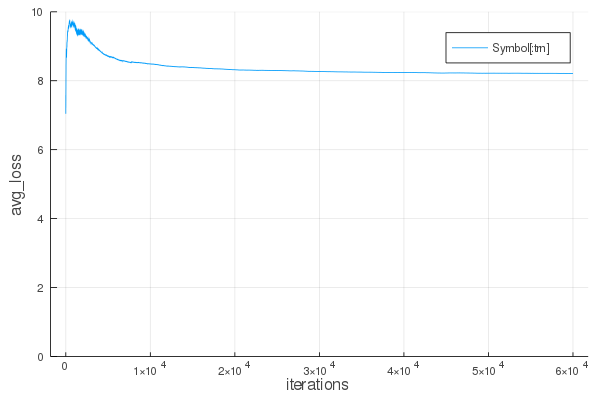

In [45]:
plot(iter, avg,ylim=(0.0,10),
     labels=[:trn],xlabel="iterations",ylabel="avg_loss")